In [1]:
# ======================
# 📌 1. Imports
# ======================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans

# Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)


In [15]:
# ======================
# 📌 2. Load & Clean Data
# ======================
df = pd.read_csv("zomato.csv", encoding="latin1")

# Standardize columns
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^a-z0-9]", "_", regex=True)
)

print(df.columns.tolist())  # confirm column names

# Clean cost column (correct one)
df["average_cost_for_two"] = (
    df["average_cost_for_two"]
    .astype(str)
    .str.replace(",", "")
    .replace("nan", np.nan)
    .astype(float)
)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Quick overview
print(df.info())
print(df.describe(include="all").T.head())


['restaurant_id', 'restaurant_name', 'country_code', 'city', 'address', 'locality', 'locality_verbose', 'longitude', 'latitude', 'cuisines', 'average_cost_for_two', 'currency', 'has_table_booking', 'has_online_delivery', 'is_delivering_now', 'switch_to_order_menu', 'price_range', 'aggregate_rating', 'rating_color', 'rating_text', 'votes']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   restaurant_id         9551 non-null   int64  
 1   restaurant_name       9551 non-null   object 
 2   country_code          9551 non-null   int64  
 3   city                  9551 non-null   object 
 4   address               9551 non-null   object 
 5   locality              9551 non-null   object 
 6   locality_verbose      9551 non-null   object 
 7   longitude             9551 non-null   float64
 8   latitude              9551 non-null  

In [6]:
# ======================
# 📌 3. Handle Missing Values
# Fill missing values sensibly
df["cuisines"].fillna("Unknown", inplace=True)
df["city"].fillna("Unknown", inplace=True)
df["aggregate_rating"].fillna(df["aggregate_rating"].median(), inplace=True)
df["average_cost_for_two"].fillna(df["average_cost_for_two"].median(), inplace=True)

# Double check
print(df.isna().sum())



In [16]:
# ======================
# 📌 4. Functions for Reusability
# ======================
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_top_counts(df, col, n=10):
    """Barplot for top categories"""
    df[col].value_counts()[:n].plot(kind="bar", color="skyblue")
    plt.title(f"Top {n} {col}")
    plt.show()

def plot_wordcloud(text_series, title):
    """Generate wordcloud"""
    text = " ".join(str(v) for v in text_series.dropna())
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()



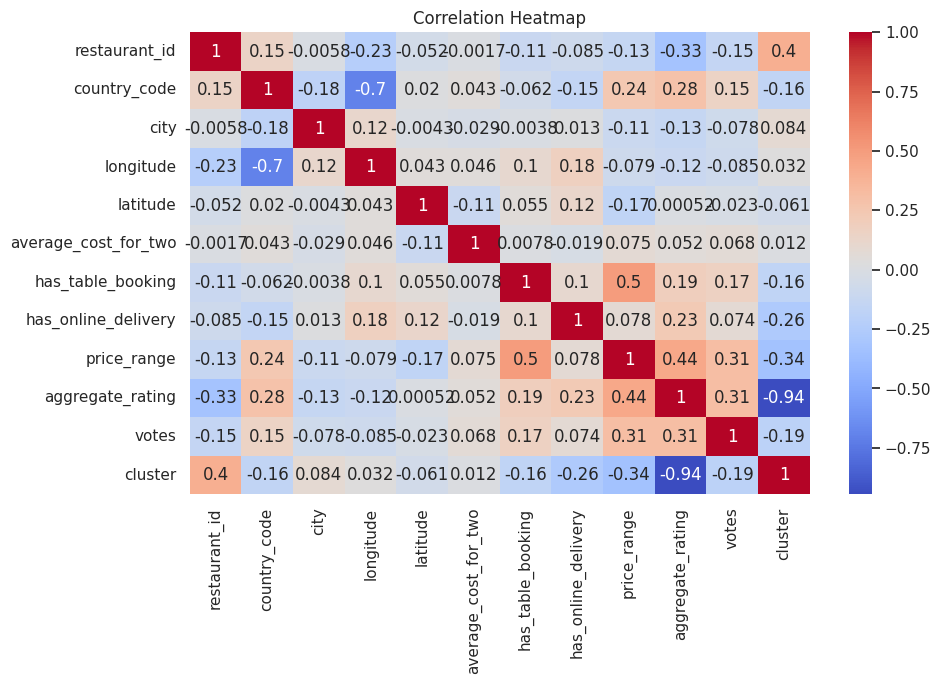

In [24]:
# ======================
# 📌 5. Extended EDA
# ======================
# Correlation heatmap (numeric only)
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



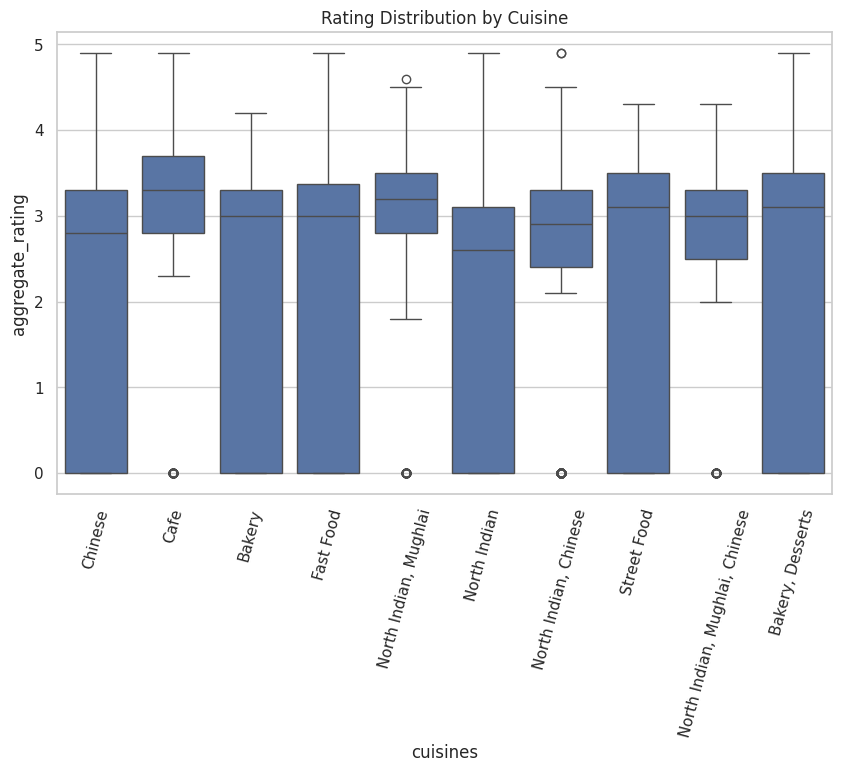

In [25]:

# Rating distribution by cuisine
top_cuisines = df["cuisines"].value_counts().index[:10]
sns.boxplot(data=df[df["cuisines"].isin(top_cuisines)], x="cuisines", y="aggregate_rating")
plt.xticks(rotation=75)
plt.title("Rating Distribution by Cuisine")
plt.show()


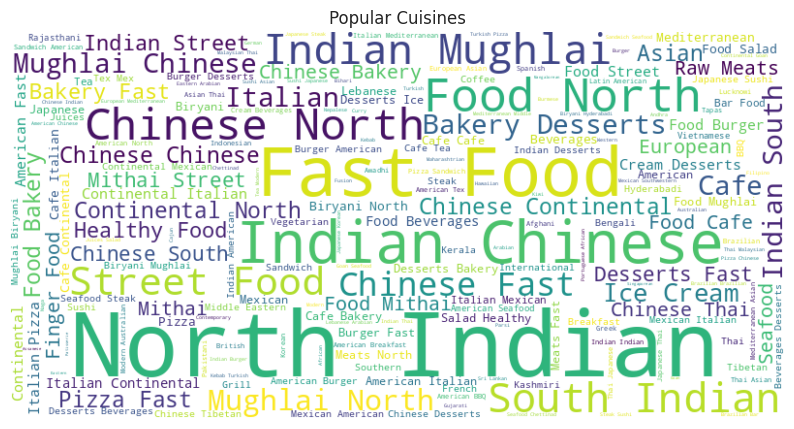

In [26]:

# Wordcloud for cuisines
plot_wordcloud(df["cuisines"], "Popular Cuisines")

In [19]:
# ======================
# 📌 6. Statistical Insights
# ======================
from scipy import stats

# ANOVA: cost vs rating by has_table_booking
anova = stats.f_oneway(
    df[df["has_table_booking"] == "Yes"]["aggregate_rating"],
    df[df["has_table_booking"] == "No"]["aggregate_rating"]
)
print("ANOVA (table booking vs rating):", anova)

# Chi-square: online_delivery vs table_booking
chi2 = pd.crosstab(df["has_online_delivery"], df["has_table_booking"])
chi2_test = stats.chi2_contingency(chi2)
print("Chi-square (online delivery vs table booking): χ² =", chi2_test[0], "p =", chi2_test[1])



ANOVA (table booking vs rating): F_onewayResult(statistic=np.float64(357.6201677056537), pvalue=np.float64(2.4808519133558066e-78))
Chi-square (online delivery vs table booking): χ² = 97.15347141039274 p = 6.415670125535211e-23


In [20]:
# ======================
# 📌 7. Machine Learning Extensions
# ======================
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Encode categoricals
le = LabelEncoder()
for col in ["has_online_delivery", "has_table_booking", "city"]:
    df[col] = le.fit_transform(df[col].astype(str))

# (A) Predict Rating (Regression)
X = df[["average_cost_for_two", "has_online_delivery", "has_table_booking"]].fillna(0)
y = df["aggregate_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model = RandomForestRegressor()
reg_model.fit(X_train, y_train)
print("Rating Prediction R²:", reg_model.score(X_test, y_test))

# (B) Predict Online Delivery (Classification)
X = df[["average_cost_for_two", "aggregate_rating", "has_table_booking"]].fillna(0)
y = df["has_online_delivery"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Online Delivery Prediction Accuracy:", clf.score(X_test, y_test))


Rating Prediction R²: 0.2897421147650001
Online Delivery Prediction Accuracy: 0.760858189429618


In [21]:
# ======================
# 📌 8. Clustering Restaurants
from sklearn.cluster import KMeans

clustering_data = df[["average_cost_for_two", "aggregate_rating"]].dropna()

scaler = StandardScaler()
scaled = scaler.fit_transform(clustering_data)

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(scaled)

import plotly.express as px
px.scatter(
    df, x="average_cost_for_two", y="aggregate_rating",
    color=df["cluster"].astype(str),
    title="Restaurant Clusters"
)



In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# ==========================
# 📌 Function: Recommender
# ==========================
def recommend_restaurants(restaurant_name, top_n=5):
    """
    Recommend similar restaurants based on cuisine + cost + rating.
    """
    if restaurant_name not in df["restaurant_name"].values:
        print("❌ Restaurant not found in dataset!")
        return []

    # --- Feature Engineering ---
    # Combine cuisines + cost + rating into text form
    df["features"] = (
        df["cuisines"].astype(str) + " " +
        df["average_cost_for_two"].astype(str) + " " +
        df["aggregate_rating"].astype(str)
    )

    # TF-IDF vectorization
    tfidf = TfidfVectorizer(stop_words="english")
    tfidf_matrix = tfidf.fit_transform(df["features"])

    # Compute cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Get index of restaurant
    idx = df.index[df["restaurant_name"] == restaurant_name][0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top N recommendations (excluding itself)
    sim_indices = [i[0] for i in sim_scores[1 : top_n + 1]]

    return df.iloc[sim_indices][["restaurant_name", "cuisines", "average_cost_for_two", "aggregate_rating"]]


In [23]:
recommendations = recommend_restaurants("Domino's Pizza", top_n=5)
print("🍽️ Recommended Restaurants:\n")
print(recommendations)


🍽️ Recommended Restaurants:

            restaurant_name          cuisines  average_cost_for_two  \
9192              Pizza Hut             Pizza                 700.0   
9237  Pizzeria Vaatika Cafe    Pizza, Chinese                 700.0   
1052         Domino's Pizza  Pizza, Fast Food                 700.0   
1130         Domino's Pizza  Pizza, Fast Food                 700.0   
1192         Domino's Pizza  Pizza, Fast Food                 700.0   

      aggregate_rating  
9192               3.5  
9237               3.7  
1052               2.9  
1130               3.2  
1192               3.4  
